In [118]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
from os import path
import itertools
from matplotlib.ticker import ScalarFormatter, LogFormatter, LogFormatterExponent, LogFormatterMathtext

In [119]:
%matplotlib inline

In [120]:
!ls data/NYT_new/

bicultural.json         monocultural.json       other ethnicity.json
biethnic.json           monoethnic.json         other race.json
biracial.json           monoracial.json         polycultural.json
cultural pluralism.json multicultural.json      polyculturalism.json
interracial.json        multiculturalism.json   polyethnic.json
mixed ethnicity.json    multiethnic.json        polyracial.json
mixed race.json         multiracial.json


In [121]:
def load_nyt_json(filename):
    obj = json.load(open(filename))
    words = obj["graph_data"]
    assert len(words) == 1
    only_word = words[0]
    term1 = only_word["term"]
    term2 = path.basename(filename).split(".")[0]
    assert term1 == term2

    df = pd.DataFrame.from_records(only_word["data"])
    df = df.rename(columns={"total_articles_published": "Total", "article_matches": term1})
    database = df[["Total", term1, "year"]]
    return term1, database

In [122]:
def load_nyt_database():
    word, database = load_nyt_json("data/NYT_new/bicultural.json")

    for file in glob.glob("data/NYT_new/*json"):
      word, df = load_nyt_json(file)
      if word == "bicultural": continue
      df.drop("Total", 1, inplace=True)
      df = df.rename(columns={"article_matches": word})
      database = pd.merge(database, df, on="year", how="outer")

    database.set_index("year", inplace=True)
    values = (database.values.T / database.Total.values).T
    values[:, 0] = database.Total.values
    database_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)
    return database_norm

In [123]:
database_norm = load_nyt_database()

In [124]:
class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag

In [183]:
def plot(words):
    #markers = itertools.cycle(['s', 'D', '*', 'p', 'h', 'o', '+', 'd'])
    line_types = itertools.cycle(['-', '--', '-.', ':'])
    df = database_norm[words] * 100
    #df = pd.rolling_mean(database_norm[words], 10)
    df = pd.rolling_mean(df, 10)
    plt.figure(figsize=(16,6))

    for i,word in enumerate(words):
        plt.plot(df.index, df[word], next(line_types), linewidth=2,
                 color=str(i/float(len(words)))),
    axis_1 = plt.gca()

    axis_1.set_yscale('log') # You can disable
    axis_1.set_ylim(1e-4, 3e-1) # You can disable
    axis_1.yaxis.set_major_formatter(LogFormatterMathtext())  # You can disable

    axis_1.set_ylabel("Percentage of New York Times Articles ($\%$)")
    axis_1.set_xlabel("Year")
    #axis_1.yaxis.set_major_formatter(FixedOrderFormatter(-3)) # You can enable
    plt.legend(words, loc=2)

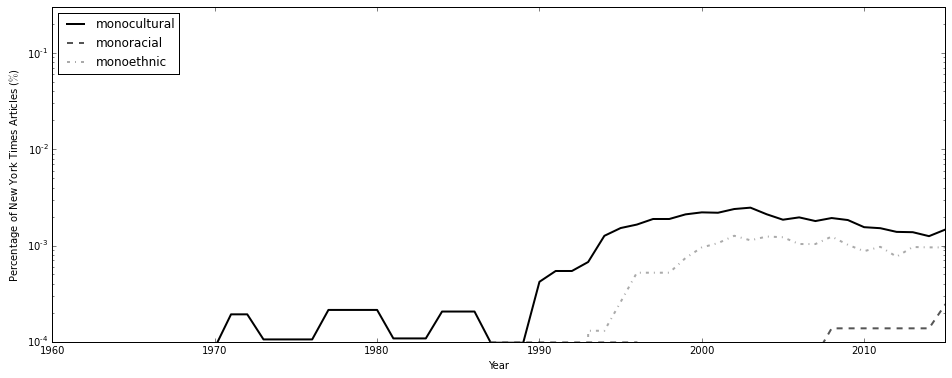

In [185]:
words = ['monocultural', 'monoracial', 'monoethnic']
plot(words)
_ = plt.xlim(1960, 2015)

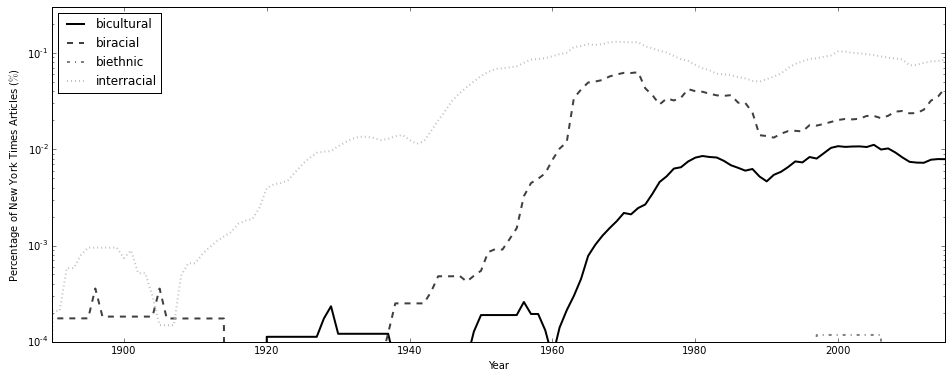

In [186]:
words = ['bicultural', 'biracial', 'biethnic', 'interracial']
plot(words)
_ = plt.xlim(1890, 2015)

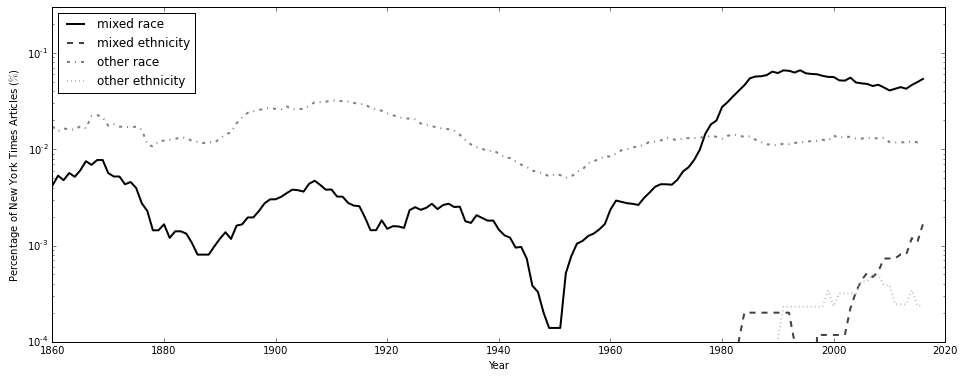

In [187]:
words = ['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity']
plot(words)

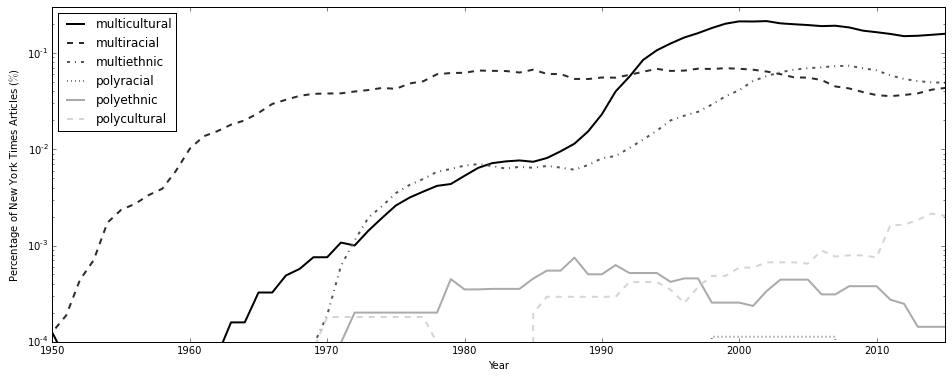

In [188]:
words = ['multicultural', 'multiracial', 'multiethnic', 'polyracial', 'polyethnic', 'polycultural']
plot(words)
_ = plt.xlim(1950, 2015)

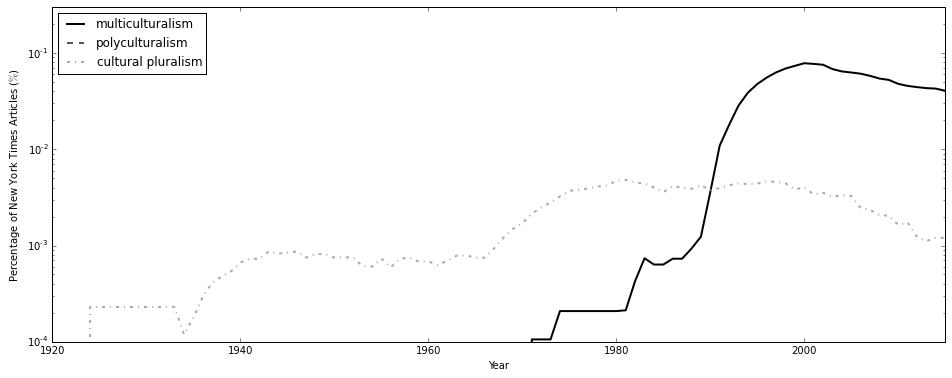

In [189]:
words = ['multiculturalism', 'polyculturalism', 'cultural pluralism']
plot(words)
_ = plt.xlim(1920, 2015)

polyculturalism has no frequency in NYT

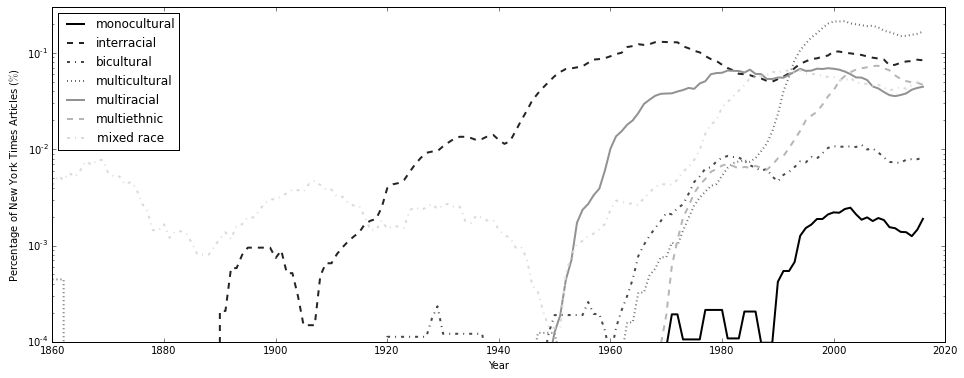

In [190]:
words = ['monocultural', 'interracial', 'bicultural', 'multicultural', 'multiracial', 'multiethnic', 'mixed race']
plot(words)

# To Do

1. Fix plots (not identical to previous smoothened plots)
1. Strange gap at the bottom (I tried to fix this by changing the y-limit)